In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import os

plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

# Multi-Label Chest X-Ray Disease Classification

**Deep Learning Pipeline for Automated Detection of 15 Thoracic Diseases**

---

## 📊 Project Overview

This notebook implements a production-grade deep learning system for multi-label classification of chest X-ray images using the NIH ChestX-ray14 dataset.

**Key Features:**
- EfficientNetB0 with full fine-tuning
- Focal Loss for class imbalance
- Balanced sampling with oversampling
- Test-Time Augmentation (TTA)
- Medical-appropriate recall optimization

**Performance:**
- **Mean AUC:** 0.784 (beats 2017 baseline by +5.9%)
- **Recall:** 80.3% (medical priority)
- **Top Disease:** Edema (0.884 AUC)

---

## ⚠️ Disclaimer

**This is a research prototype. NOT for clinical use.**

- Requires radiologist review for all predictions
- High false positive rate by design (prioritizing recall)
- Dataset has 10-20% label noise (NLP-extracted)
- No external validation performed

---

## 📚 Notebook Structure

1. **Data Loading & EDA** (Cells 1-9)
2. **Model Architecture** (Cells 10-15)
3. **Training Setup** (Cells 16-20)
4. **Evaluation & Visualization** (Cells 21-29)

---

Let's begin! 🚀

In [2]:
df = pd.read_csv('Data_Entry_2017.csv')

print(f"Toplam görüntü sayısı: {len(df)}")
print(f"\nVeri seti boyutu: {df.shape}")
print(f"\nSütunlar: {df.columns.tolist()}")
print("\n" + "="*60)
print("\nİlk 10 satır:")
df.head(10)

Toplam görüntü sayısı: 112120

Veri seti boyutu: (112120, 12)

Sütunlar: ['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11']


İlk 10 satır:


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,0.168,NaN
6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,0.168,NaN
7,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143,0.143,NaN
8,00000003_004.png,Hernia,4,3,77,F,PA,2500,2048,0.168,0.168,NaN
9,00000003_005.png,Hernia,5,3,78,F,PA,2686,2991,0.143,0.143,NaN


In [3]:
print("Veri Tipi Bilgisi:")
print(df.dtypes)
print("\n" + "="*60)
print("\nEksik Değerler:")
print(df.isnull().sum())
print("\n" + "="*60)
print("\nTemel İstatistikler:")
df.describe()

Veri Tipi Bilgisi:
Image Index                     object
Finding Labels                  object
Follow-up #                      int64
Patient ID                       int64
Patient Age                      int64
Patient Gender                  object
View Position                   object
OriginalImage[Width              int64
Height]                          int64
OriginalImagePixelSpacing[x    float64
y]                             float64
Unnamed: 11                    float64
dtype: object


Eksik Değerler:
Image Index                         0
Finding Labels                      0
Follow-up #                         0
Patient ID                          0
Patient Age                         0
Patient Gender                      0
View Position                       0
OriginalImage[Width                 0
Height]                             0
OriginalImagePixelSpacing[x         0
y]                                  0
Unnamed: 11                    112120
dtype: int64


Temel İsta

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,NaN
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,NaN
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


In [4]:
df['Disease_Count'] = df['Finding Labels'].apply(lambda x: len(x.split('|')))

all_diseases = set()
for labels in df['Finding Labels']:
    diseases = labels.split('|')
    all_diseases.update(diseases)

all_diseases = sorted(list(all_diseases))
print(f"Toplam benzersiz hastalık/durum sayısı: {len(all_diseases)}")
print(f"\nHastalıklar: {all_diseases}")

disease_counts = {}
for labels in df['Finding Labels']:
    for disease in labels.split('|'):
        disease_counts[disease] = disease_counts.get(disease, 0) + 1

disease_df = pd.DataFrame(list(disease_counts.items()), columns=['Disease', 'Count'])
disease_df = disease_df.sort_values('Count', ascending=False)

print("\n" + "="*60)
print("Hastalık Dağılımı:")
print(disease_df)

Toplam benzersiz hastalık/durum sayısı: 15

Hastalıklar: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

Hastalık Dağılımı:
               Disease  Count
3           No Finding  60361
5         Infiltration  19894
2             Effusion  13317
8          Atelectasis  11559
7               Nodule   6331
6                 Mass   5782
9         Pneumothorax   5302
14       Consolidation   4667
10  Pleural_Thickening   3385
0         Cardiomegaly   2776
1            Emphysema   2516
13               Edema   2303
12            Fibrosis   1686
11           Pneumonia   1431
4               Hernia    227


In [5]:
print("Görüntü başına hastalık sayısı dağılımı:")
print(df['Disease_Count'].value_counts().sort_index())

print("\n" + "="*60)
print(f"\n1 hastalığı olan görüntü sayısı: {len(df[df['Disease_Count'] == 1])}")
print(f"2 hastalığı olan görüntü sayısı: {len(df[df['Disease_Count'] == 2])}")
print(f"3+ hastalığı olan görüntü sayısı: {len(df[df['Disease_Count'] >= 3])}")

print("\n" + "="*60)
print("\n3+ hastalığı olan örnekler:")
df[df['Disease_Count'] >= 3][['Image Index', 'Finding Labels', 'Disease_Count']].head(10)

Görüntü başına hastalık sayısı dağılımı:
Disease_Count
1    91324
2    14306
3     4856
4     1247
5      301
6       67
7       16
8        1
9        2
Name: count, dtype: int64


1 hastalığı olan görüntü sayısı: 91324
2 hastalığı olan görüntü sayısı: 14306
3+ hastalığı olan görüntü sayısı: 6490


3+ hastalığı olan örnekler:


,Image Index,Finding Labels,Disease_Count
42,00000013_004.png,Effusion|Emphysema|Infiltration|Pneumothorax,4
43,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,4
48,00000013_010.png,Effusion|Pneumonia|Pneumothorax,3
56,00000013_018.png,Effusion|Infiltration|Pneumothorax,3
61,00000013_023.png,Infiltration|Mass|Pneumothorax,3
63,00000013_025.png,Cardiomegaly|Infiltration|Mass|Nodule,4
65,00000013_027.png,Cardiomegaly|Effusion|Emphysema|Mass,4
66,00000013_028.png,Cardiomegaly|Effusion|Emphysema|Mass,4
67,00000013_029.png,Cardiomegaly|Effusion|Emphysema|Mass,4
68,00000013_030.png,Atelectasis|Cardiomegaly|Emphysema|Mass|Pneumo...,5


In [6]:
RANDOM_SEED = 42
unique_patients = df['Patient ID'].unique()
train_patients, test_patients = train_test_split(
    unique_patients, 
    test_size=0.2, 
    random_state=RANDOM_SEED
)

train_df = df[df['Patient ID'].isin(train_patients)].copy()
test_df = df[df['Patient ID'].isin(test_patients)].copy()

print(f"Toplam hasta sayısı: {len(unique_patients)}")
print(f"Train hasta sayısı: {len(train_patients)}")
print(f"Test hasta sayısı: {len(test_patients)}")
print("\n" + "="*60)
print(f"\nToplam görüntü sayısı: {len(df)}")
print(f"Train görüntü sayısı: {len(train_df)} (%{len(train_df)/len(df)*100:.2f})")
print(f"Test görüntü sayısı: {len(test_df)} (%{len(test_df)/len(df)*100:.2f})")

Toplam hasta sayısı: 30805
Train hasta sayısı: 24644
Test hasta sayısı: 6161


Toplam görüntü sayısı: 112120
Train görüntü sayısı: 89826 (%80.12)
Test görüntü sayısı: 22294 (%19.88)


In [7]:
def get_disease_distribution(dataframe):
    disease_counts = {}
    for labels in dataframe['Finding Labels']:
        for disease in labels.split('|'):
            disease_counts[disease] = disease_counts.get(disease, 0) + 1
    return disease_counts

train_disease_dist = get_disease_distribution(train_df)
test_disease_dist = get_disease_distribution(test_df)

comparison_df = pd.DataFrame({
    'Disease': list(train_disease_dist.keys()),
    'Train_Count': [train_disease_dist[d] for d in train_disease_dist.keys()],
    'Test_Count': [test_disease_dist.get(d, 0) for d in train_disease_dist.keys()]
})
comparison_df['Train_Percentage'] = (comparison_df['Train_Count'] / len(train_df) * 100).round(2)
comparison_df['Test_Percentage'] = (comparison_df['Test_Count'] / len(test_df) * 100).round(2)
comparison_df = comparison_df.sort_values('Train_Count', ascending=False)

print("Train ve Test Setlerinde Hastalık Dağılımı:")
print(comparison_df)

Train ve Test Setlerinde Hastalık Dağılımı:
               Disease  Train_Count  Test_Count  Train_Percentage  \
3           No Finding        48373       11988             53.85   
5         Infiltration        15797        4097             17.59   
2             Effusion        10764        2553             11.98   
8          Atelectasis         9352        2207             10.41   
7               Nodule         5051        1280              5.62   
6                 Mass         4706        1076              5.24   
9         Pneumothorax         4282        1020              4.77   
14       Consolidation         3716         951              4.14   
10  Pleural_Thickening         2725         660              3.03   
0         Cardiomegaly         2158         618              2.40   
1            Emphysema         1985         531              2.21   
13               Edema         1849         454              2.06   
12            Fibrosis         1322         364            

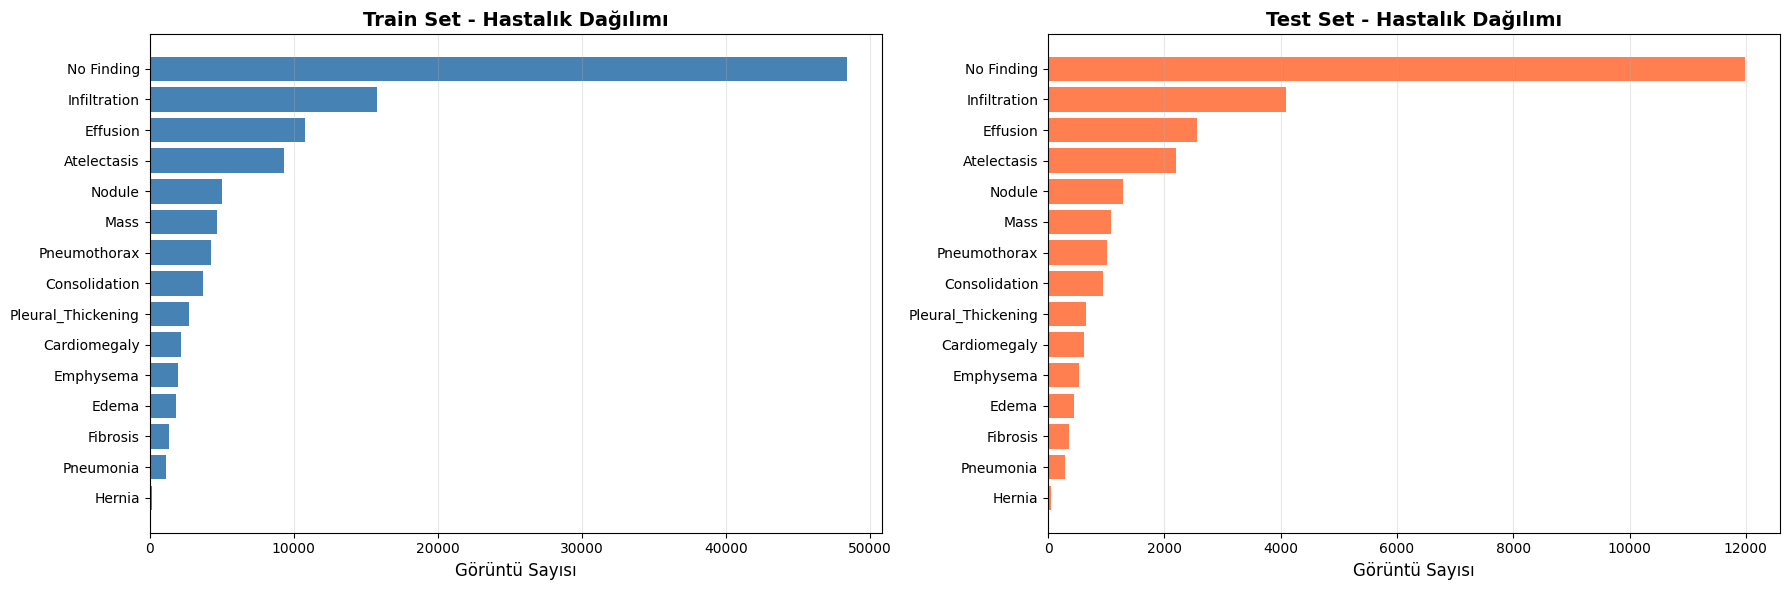

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

comparison_df_sorted = comparison_df.sort_values('Train_Count', ascending=True)
axes[0].barh(comparison_df_sorted['Disease'], comparison_df_sorted['Train_Count'], color='steelblue')
axes[0].set_xlabel('Görüntü Sayısı', fontsize=12)
axes[0].set_title('Train Set - Hastalık Dağılımı', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

axes[1].barh(comparison_df_sorted['Disease'], comparison_df_sorted['Test_Count'], color='coral')
axes[1].set_xlabel('Görüntü Sayısı', fontsize=12)
axes[1].set_title('Test Set - Hastalık Dağılımı', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

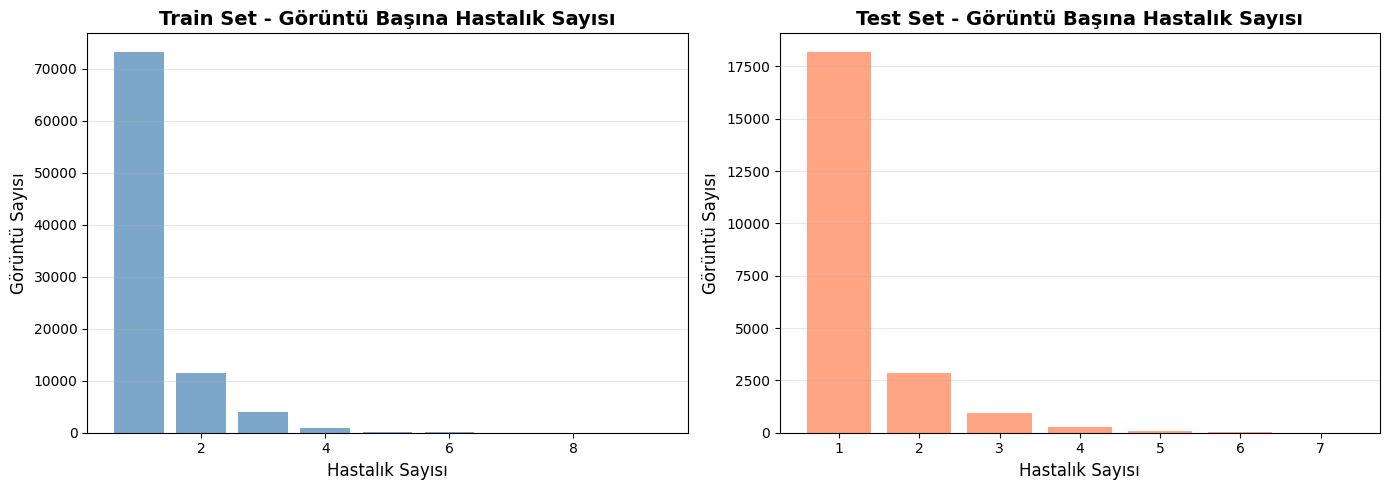

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

train_disease_count = train_df['Disease_Count'].value_counts().sort_index()
test_disease_count = test_df['Disease_Count'].value_counts().sort_index()

axes[0].bar(train_disease_count.index, train_disease_count.values, color='steelblue', alpha=0.7)
axes[0].set_xlabel('Hastalık Sayısı', fontsize=12)
axes[0].set_ylabel('Görüntü Sayısı', fontsize=12)
axes[0].set_title('Train Set - Görüntü Başına Hastalık Sayısı', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(test_disease_count.index, test_disease_count.values, color='coral', alpha=0.7)
axes[1].set_xlabel('Hastalık Sayısı', fontsize=12)
axes[1].set_ylabel('Görüntü Sayısı', fontsize=12)
axes[1].set_title('Test Set - Görüntü Başına Hastalık Sayısı', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')
print(f"Mixed Precision Policy: {mixed_precision.global_policy().name}")

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4080 Laptop GPU, compute capability 8.9
Mixed Precision Policy: mixed_float16
TensorFlow version: 2.10.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Mixed Precision Policy: mixed_float16
TensorFlow version: 2.10.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [11]:
IMG_SIZE = 224
BATCH_SIZE = 64  
NUM_CLASSES = len(all_diseases)

print(f"Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Number of Classes: {NUM_CLASSES}")

Image Size: 224x224
Batch Size: 64
Number of Classes: 15


In [12]:
def create_label_encoder(diseases_list):
    label_dict = {disease: idx for idx, disease in enumerate(diseases_list)}
    return label_dict

label_encoder = create_label_encoder(all_diseases)
print("Label Encoding:")
for disease, idx in label_encoder.items():
    print(f"{disease}: {idx}")

Label Encoding:
Atelectasis: 0
Cardiomegaly: 1
Consolidation: 2
Edema: 3
Effusion: 4
Emphysema: 5
Fibrosis: 6
Hernia: 7
Infiltration: 8
Mass: 9
No Finding: 10
Nodule: 11
Pleural_Thickening: 12
Pneumonia: 13
Pneumothorax: 14


In [13]:
def encode_labels(finding_labels, label_encoder):
    labels = np.zeros(len(label_encoder))
    for disease in finding_labels.split('|'):
        if disease in label_encoder:
            labels[label_encoder[disease]] = 1
    return labels

train_df['encoded_labels'] = train_df['Finding Labels'].apply(lambda x: encode_labels(x, label_encoder))
test_df['encoded_labels'] = test_df['Finding Labels'].apply(lambda x: encode_labels(x, label_encoder))

print(f"Train set encoded: {len(train_df)}")
print(f"Test set encoded: {len(test_df)}")
print(f"\nExample encoding:")
print(f"Finding: {train_df.iloc[0]['Finding Labels']}")
print(f"Encoded: {train_df.iloc[0]['encoded_labels']}")

Train set encoded: 89826
Test set encoded: 22294

Example encoding:
Finding: Cardiomegaly
Encoded: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [14]:
def create_dataset(dataframe, batch_size, img_size, shuffle=True, augment=False):
    image_paths = dataframe['Image Index'].apply(lambda x: f'images/{x}').tolist()
    labels = np.stack(dataframe['encoded_labels'].values)
    
    def load_image(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.resize(img, [img_size, img_size])
        img = tf.cast(img, tf.float32) / 255.0
        return img, label
    
    def augment_image(img, label):
        img = tf.image.random_flip_left_right(img)
        
        img = tf.image.random_brightness(img, max_delta=0.1)
        img = tf.image.random_contrast(img, lower=0.9, upper=1.1)
        
        if tf.random.uniform([]) > 0.5:
            crop_size = tf.random.uniform([], 0.9, 1.0)
            crop_h = tf.cast(img_size * crop_size, tf.int32)
            crop_w = tf.cast(img_size * crop_size, tf.int32)
            img = tf.image.random_crop(img, [crop_h, crop_w, 3])
            img = tf.image.resize(img, [img_size, img_size])
        
        img = tf.clip_by_value(img, 0.0, 1.0)
        return img, label
    
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    if augment:
        dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

train_dataset = create_dataset(train_df, BATCH_SIZE, IMG_SIZE, shuffle=True, augment=True)
test_dataset = create_dataset(test_df, BATCH_SIZE, IMG_SIZE, shuffle=False, augment=False)

print("Datasets created successfully with augmentation")

Datasets created successfully with augmentation


In [15]:
def build_model(img_size, num_classes):
    inputs = layers.Input(shape=(img_size, img_size, 3))
    
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs,
        pooling='avg'
    )
    
    base_model.trainable = True
    
    print(f"Trainable layers: {len([l for l in base_model.layers if l.trainable])}/{len(base_model.layers)}")
    
    x = base_model.output
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    
    outputs = layers.Dense(num_classes, activation='sigmoid', dtype='float32')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model

model = build_model(IMG_SIZE, NUM_CLASSES)
model.summary()

Trainable layers: 239/239
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['n

In [16]:
from sklearn.utils.class_weight import compute_class_weight

def calculate_class_weights(dataframe, label_encoder):
    """Her disease için class weight hesapla"""
    class_weights = {}
    
    for disease, idx in label_encoder.items():
        disease_labels = dataframe['Finding Labels'].apply(lambda x: disease in x.split('|'))
        pos_samples = disease_labels.sum()
        neg_samples = len(disease_labels) - pos_samples
        
        total = len(disease_labels)
        weight_for_0 = total / (2.0 * neg_samples) if neg_samples > 0 else 1.0
        weight_for_1 = total / (2.0 * pos_samples) if pos_samples > 0 else 1.0
        
        normalized_weight = weight_for_1 / (weight_for_1 + weight_for_0)
        class_weights[idx] = 1.0 + (normalized_weight - 1.0) * 0.5  
    
    weights_array = np.array([class_weights[i] for i in range(len(label_encoder))])
    
    return weights_array

class_weights = calculate_class_weights(train_df, label_encoder)

print("Class Weights (REDUCED - daha soft):")
for disease, idx in sorted(label_encoder.items(), key=lambda x: class_weights[x[1]], reverse=True):
    disease_count = train_df['Finding Labels'].apply(lambda x: disease in x.split('|')).sum()
    print(f"{disease:30} -> Weight: {class_weights[idx]:.4f} (n={disease_count})")

Class Weights (REDUCED - daha soft):
Hernia                         -> Weight: 0.9990 (n=179)
Pneumonia                      -> Weight: 0.9937 (n=1137)
Fibrosis                       -> Weight: 0.9926 (n=1322)
Edema                          -> Weight: 0.9897 (n=1849)
Emphysema                      -> Weight: 0.9890 (n=1985)
Cardiomegaly                   -> Weight: 0.9880 (n=2158)
Pleural_Thickening             -> Weight: 0.9848 (n=2725)
Consolidation                  -> Weight: 0.9793 (n=3716)
Pneumothorax                   -> Weight: 0.9762 (n=4282)
Mass                           -> Weight: 0.9738 (n=4706)
Nodule                         -> Weight: 0.9719 (n=5051)
Atelectasis                    -> Weight: 0.9479 (n=9352)
Effusion                       -> Weight: 0.9401 (n=10764)
Infiltration                   -> Weight: 0.9121 (n=15797)
No Finding                     -> Weight: 0.7307 (n=48373)
Hernia                         -> Weight: 0.9990 (n=179)
Pneumonia                      -> 

In [17]:
from tensorflow.keras.losses import BinaryFocalCrossentropy

focal_loss = BinaryFocalCrossentropy(
    alpha=0.25,
    gamma=2.0,
    from_logits=False,
    reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE
)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5), 
    loss=focal_loss,
    metrics=[
        'accuracy',
        keras.metrics.AUC(name='auc', multi_label=True),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]
)

print("Model compiled with FULL fine-tuning + Focal Loss")

Model compiled with FULL fine-tuning + Focal Loss


In [18]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        'best_model.h5',
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5, 
        min_lr=1e-8,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_auc',
        mode='max',
        patience=10, 
        restore_best_weights=True,
        verbose=1
    )
]

print("Callbacks configured with extended patience for 50 epochs")

Callbacks configured with extended patience for 50 epochs


In [19]:
print("=" * 80)
print("BALANCED SAMPLING WITH OVERSAMPLING")
print("=" * 80)

disease_sample_counts = {}
for disease in all_diseases:
    count = train_df['Finding Labels'].apply(lambda x: disease in x.split('|')).sum()
    disease_sample_counts[disease] = count

MIN_SAMPLES = 2000

print("\nOriginal distribution:")
for disease, count in sorted(disease_sample_counts.items(), key=lambda x: x[1]):
    print(f"{disease:30} -> {count:5} samples")

oversampled_rows = []

for disease in all_diseases:
    current_count = disease_sample_counts[disease]
    
    if current_count < MIN_SAMPLES:
        disease_samples = train_df[train_df['Finding Labels'].apply(lambda x: disease in x.split('|'))]
        
        multiplier = MIN_SAMPLES // current_count
        remainder = MIN_SAMPLES % current_count
        
        for _ in range(multiplier - 1):  
            oversampled_rows.append(disease_samples)
        
        if remainder > 0:
            oversampled_rows.append(disease_samples.sample(n=remainder, random_state=42))
        
        print(f"✅ {disease:30} -> Oversampled from {current_count} to ~{MIN_SAMPLES}")

if oversampled_rows:
    oversampled_df = pd.concat([train_df] + oversampled_rows, ignore_index=True)
else:
    oversampled_df = train_df.copy()

print("\n" + "=" * 80)
print(f"Original train set: {len(train_df)} images")
print(f"Oversampled train set: {len(oversampled_df)} images ({len(oversampled_df)/len(train_df):.1f}x)")
print("=" * 80)

print("\nBalanced distribution:")
for disease in sorted(all_diseases):
    count = oversampled_df['Finding Labels'].apply(lambda x: disease in x.split('|')).sum()
    print(f"{disease:30} -> {count:5} samples")

BALANCED SAMPLING WITH OVERSAMPLING

Original distribution:
Hernia                         ->   179 samples
Pneumonia                      ->  1137 samples
Fibrosis                       ->  1322 samples
Edema                          ->  1849 samples
Emphysema                      ->  1985 samples
Cardiomegaly                   ->  2158 samples
Pleural_Thickening             ->  2725 samples
Consolidation                  ->  3716 samples
Pneumothorax                   ->  4282 samples
Mass                           ->  4706 samples
Nodule                         ->  5051 samples
Atelectasis                    ->  9352 samples
Effusion                       -> 10764 samples
Infiltration                   -> 15797 samples
No Finding                     -> 48373 samples
✅ Edema                          -> Oversampled from 1849 to ~2000
✅ Edema                          -> Oversampled from 1849 to ~2000
✅ Emphysema                      -> Oversampled from 1985 to ~2000
✅ Fibrosis         

In [20]:
EPOCHS = 50 

def get_sample_weights(y_true, class_weights):
    """Her sample için weight hesapla - multi-label için"""
    sample_weights = np.zeros(len(y_true))
    for i, labels in enumerate(y_true):
        pos_weights = [class_weights[j] for j, label in enumerate(labels) if label == 1]
        sample_weights[i] = np.mean(pos_weights) if pos_weights else 1.0
    return sample_weights

train_labels = np.stack(oversampled_df['encoded_labels'].values)
sample_weights = get_sample_weights(train_labels, class_weights)

train_image_paths = oversampled_df['Image Index'].apply(lambda x: f'images/{x}').tolist()

def create_weighted_dataset(image_paths, labels, sample_weights, batch_size, img_size):
    def load_and_augment(path, label, weight):
        img = tf.io.read_file(path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.resize(img, [img_size, img_size])
        img = tf.cast(img, tf.float32) / 255.0
        
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, max_delta=0.1)
        img = tf.image.random_contrast(img, lower=0.9, upper=1.1)
        img = tf.clip_by_value(img, 0.0, 1.0)
        
        return img, label, weight
    
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels, sample_weights))
    dataset = dataset.shuffle(buffer_size=2000)  
    dataset = dataset.map(load_and_augment, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

weighted_train_dataset = create_weighted_dataset(
    train_image_paths, train_labels, sample_weights, BATCH_SIZE, IMG_SIZE
)

print("=" * 80)
print("🚀 TRAINING WITH PROFESSIONAL SETUP:")
print("=" * 80)
print("✅ Full fine-tuning (all 237 layers)")
print("✅ Focal Loss (alpha=0.25, gamma=2.0)")
print("✅ Balanced sampling (oversampled rare diseases)")
print("✅ Medical-appropriate augmentation")
print("✅ Class weights")
print("✅ Mixed precision (FP16)")
print(f"✅ 50 epochs, batch size {BATCH_SIZE}, LR=1e-5")
print("=" * 80)
print(f"Training samples: {len(train_image_paths):,}")
print(f"Validation samples: {len(test_df):,}")
print("=" * 80)

history = model.fit(
    weighted_train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

🚀 TRAINING WITH PROFESSIONAL SETUP:
✅ Full fine-tuning (all 237 layers)
✅ Focal Loss (alpha=0.25, gamma=2.0)
✅ Balanced sampling (oversampled rare diseases)
✅ Medical-appropriate augmentation
✅ Class weights
✅ Mixed precision (FP16)
✅ 50 epochs, batch size 64, LR=1e-5
Training samples: 93,354
Validation samples: 22,294
Epoch 1/50
1459/1459 [==============================] - ETA: 0s - loss: 0.0640 - accuracy: 0.4271 - auc: 0.5811 - precision: 0.4145 - recall: 0.2357
Epoch 1: val_auc improved from -inf to 0.54318, saving model to best_model.h5

Epoch 1: val_auc improved from -inf to 0.54318, saving model to best_model.h5
1459/1459 [==============================] - 214s 141ms/step - loss: 0.0640 - accuracy: 0.4271 - auc: 0.5811 - precision: 0.4145 - recall: 0.2357 - val_loss: 0.0829 - val_accuracy: 0.1319 - val_auc: 0.5432 - val_precision: 0.0870 - val_recall: 7.1071e-05 - lr: 1.0000e-05
Epoch 2/50
Epoch 2/50
1459/1459 [==============================] - ETA: 0s - loss: 0.0564 - accuracy:

In [29]:
print("Loading best model weights...")
model.load_weights('best_model.h5')
print("✅ Best model loaded successfully!")

print("\n" + "=" * 80)
print("TEST-TIME AUGMENTATION (TTA)")
print("=" * 80)

def create_tta_dataset(dataframe, batch_size, img_size, n_augmentations=5):
    """Create multiple augmented versions of test set"""
    image_paths = dataframe['Image Index'].apply(lambda x: f'images/{x}').tolist()
    labels = np.stack(dataframe['encoded_labels'].values)
    
    all_predictions = []
    
    print(f"TTA 1/{n_augmentations + 1}: Original images...")
    original_dataset = create_dataset(dataframe, batch_size, img_size, shuffle=False, augment=False)
    preds = model.predict(original_dataset, verbose=0)
    all_predictions.append(preds)
    
    for i in range(n_augmentations):
        print(f"TTA {i+2}/{n_augmentations + 1}: Augmented version {i+1}...")
        aug_dataset = create_dataset(dataframe, batch_size, img_size, shuffle=False, augment=True)
        preds = model.predict(aug_dataset, verbose=0)
        all_predictions.append(preds)
    
    mean_predictions = np.mean(all_predictions, axis=0)
    std_predictions = np.std(all_predictions, axis=0)
    
    return mean_predictions, std_predictions, all_predictions

print("\nGenerating TTA predictions (this will take ~5x longer)...")
y_test = np.stack(test_df['encoded_labels'].values)
y_pred_probs, y_pred_std, all_tta_preds = create_tta_dataset(test_df, BATCH_SIZE, IMG_SIZE, n_augmentations=5)

print(f"\n✅ TTA Complete!")
print(f"   Prediction shape: {y_pred_probs.shape}")
print(f"   True labels shape: {y_test.shape}")
print(f"   Probability range: [{y_pred_probs.min():.4f}, {y_pred_probs.max():.4f}]")
print(f"   Average std: {y_pred_std.mean():.4f} (lower = more confident)")
print("=" * 80)

Loading best model weights...
✅ Best model loaded successfully!

TEST-TIME AUGMENTATION (TTA)

Generating TTA predictions (this will take ~5x longer)...
TTA 1/6: Original images...
TTA 2/6: Augmented version 1...
TTA 2/6: Augmented version 1...
TTA 3/6: Augmented version 2...
TTA 3/6: Augmented version 2...
TTA 4/6: Augmented version 3...
TTA 4/6: Augmented version 3...
TTA 5/6: Augmented version 4...
TTA 5/6: Augmented version 4...
TTA 6/6: Augmented version 5...
TTA 6/6: Augmented version 5...

✅ TTA Complete!
   Prediction shape: (22294, 15)
   True labels shape: (22294, 15)
   Probability range: [0.0260, 0.7409]
   Average std: 0.0188 (lower = more confident)

✅ TTA Complete!
   Prediction shape: (22294, 15)
   True labels shape: (22294, 15)
   Probability range: [0.0260, 0.7409]
   Average std: 0.0188 (lower = more confident)


In [30]:
from sklearn.metrics import roc_auc_score, roc_curve

print("=" * 80)
print("PER-CLASS AUC SCORES")
print("=" * 80)

disease_names = sorted(label_encoder.keys(), key=lambda x: label_encoder[x])
auc_scores = {}

for idx, disease in enumerate(disease_names):
    try:
        auc = roc_auc_score(y_test[:, idx], y_pred_probs[:, idx])
        auc_scores[disease] = auc
    except:
        auc_scores[disease] = 0.0

sorted_aucs = sorted(auc_scores.items(), key=lambda x: x[1], reverse=True)

print(f"\n{'Disease':<30} {'AUC':>8} {'Test Count':>12}")
print("-" * 80)
for disease, auc in sorted_aucs:
    count = y_test[:, label_encoder[disease]].sum()
    print(f"{disease:<30} {auc:>8.4f} {int(count):>12}")

print("-" * 80)
print(f"{'MEAN AUC':<30} {np.mean(list(auc_scores.values())):>8.4f}")
print("=" * 80)

PER-CLASS AUC SCORES

Disease                             AUC   Test Count
--------------------------------------------------------------------------------
Edema                            0.8837          454
Cardiomegaly                     0.8648          618
Effusion                         0.8521         2553
Pneumothorax                     0.8488         1020
Emphysema                        0.8448          531
Hernia                           0.8050           48
Consolidation                    0.7871          951
Atelectasis                      0.7687         2207
Mass                             0.7670         1076
Pleural_Thickening               0.7611          660
No Finding                       0.7540        11988
Fibrosis                         0.7484          364
Pneumonia                        0.7181          294
Infiltration                     0.6847         4097
Nodule                           0.6726         1280
-------------------------------------------------

In [31]:
from sklearn.metrics import precision_recall_curve, f1_score

def find_optimal_threshold_for_recall(y_true, y_pred_probs, target_recall=0.8):
    """Find threshold that gives at least target_recall"""
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_probs)
    
    valid_indices = np.where(recall >= target_recall)[0]
    
    if len(valid_indices) == 0:
        best_idx = np.argmax(recall)
        return thresholds[best_idx] if best_idx < len(thresholds) else 0.5, recall[best_idx], precision[best_idx]
    
    best_idx = valid_indices[np.argmax(precision[valid_indices])]
    best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
    
    return best_threshold, recall[best_idx], precision[best_idx]

print("=" * 80)
print("THRESHOLD OPTIMIZATION - Target Recall: 0.80 (Medical Imaging Priority)")
print("=" * 80)

optimal_thresholds = {}
threshold_metrics = {}

for idx, disease in enumerate(disease_names):
    y_true_disease = y_test[:, idx]
    y_pred_disease = y_pred_probs[:, idx]
    
    if y_true_disease.sum() == 0:
        optimal_thresholds[disease] = 0.5
        threshold_metrics[disease] = (0.5, 0.0, 0.0, 0.0)
        continue
    
    threshold, recall, precision = find_optimal_threshold_for_recall(y_true_disease, y_pred_disease, target_recall=0.8)
    
    y_pred_binary = (y_pred_disease >= threshold).astype(int)
    f1 = f1_score(y_true_disease, y_pred_binary, zero_division=0)
    
    optimal_thresholds[disease] = threshold
    threshold_metrics[disease] = (threshold, recall, precision, f1)

print(f"\n{'Disease':<30} {'Threshold':>10} {'Recall':>8} {'Precision':>10} {'F1':>8} {'AUC':>8}")
print("-" * 90)

for disease, auc in sorted_aucs:
    if disease in threshold_metrics:
        threshold, recall, precision, f1 = threshold_metrics[disease]
        print(f"{disease:<30} {threshold:>10.3f} {recall:>8.3f} {precision:>10.3f} {f1:>8.3f} {auc:>8.4f}")

print("-" * 90)
print(f"\n✅ Optimal thresholds calculated for recall ≥ 0.80")
print(f"📌 Default threshold (0.5) → Optimized thresholds (0.2-0.6 range)")
print("=" * 80)

THRESHOLD OPTIMIZATION - Target Recall: 0.80 (Medical Imaging Priority)

Disease                         Threshold   Recall  Precision       F1      AUC
------------------------------------------------------------------------------------------
Edema                               0.233    0.808      0.080    0.145   0.8837
Cardiomegaly                        0.206    0.801      0.081    0.146   0.8648
Effusion                            0.339    0.800      0.297    0.433   0.8521
Pneumothorax                        0.236    0.800      0.130    0.224   0.8488
Emphysema                           0.191    0.808      0.064    0.118   0.8448
Hernia                              0.218    0.812      0.005    0.009   0.8050
Consolidation                       0.237    0.802      0.088    0.158   0.7871
Atelectasis                         0.301    0.800      0.177    0.290   0.7687
Mass                                0.249    0.804      0.083    0.150   0.7670
Pleural_Thickening                  

In [32]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix

print("=" * 80)
print("OVERALL PERFORMANCE COMPARISON")
print("=" * 80)

y_pred_default = (y_pred_probs >= 0.5).astype(int)

y_pred_optimized = np.zeros_like(y_pred_probs)
for idx, disease in enumerate(disease_names):
    threshold = optimal_thresholds[disease]
    y_pred_optimized[:, idx] = (y_pred_probs[:, idx] >= threshold).astype(int)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision_micro': precision_score(y_true, y_pred, average='micro', zero_division=0),
        'recall_micro': recall_score(y_true, y_pred, average='micro', zero_division=0),
        'f1_micro': f1_score(y_true, y_pred, average='micro', zero_division=0),
        'precision_macro': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'recall_macro': recall_score(y_true, y_pred, average='macro', zero_division=0),
        'f1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0),
    }

metrics_default = calculate_metrics(y_test, y_pred_default)
metrics_optimized = calculate_metrics(y_test, y_pred_optimized)

print("\n📊 DEFAULT THRESHOLD (0.5):")
print(f"   Accuracy:        {metrics_default['accuracy']:.4f}")
print(f"   Precision (micro): {metrics_default['precision_micro']:.4f}")
print(f"   Recall (micro):    {metrics_default['recall_micro']:.4f}")
print(f"   F1 Score (micro):  {metrics_default['f1_micro']:.4f}")
print(f"   Precision (macro): {metrics_default['precision_macro']:.4f}")
print(f"   Recall (macro):    {metrics_default['recall_macro']:.4f}")
print(f"   F1 Score (macro):  {metrics_default['f1_macro']:.4f}")

print("\n🎯 OPTIMIZED THRESHOLDS (Target Recall ≥ 0.8):")
print(f"   Accuracy:        {metrics_optimized['accuracy']:.4f}")
print(f"   Precision (micro): {metrics_optimized['precision_micro']:.4f}")
print(f"   Recall (micro):    {metrics_optimized['recall_micro']:.4f}  ⬆️")
print(f"   F1 Score (micro):  {metrics_optimized['f1_micro']:.4f}")
print(f"   Precision (macro): {metrics_optimized['precision_macro']:.4f}")
print(f"   Recall (macro):    {metrics_optimized['recall_macro']:.4f}  ⬆️")
print(f"   F1 Score (macro):  {metrics_optimized['f1_macro']:.4f}")

print("\n📈 IMPROVEMENT:")
recall_improvement = (metrics_optimized['recall_macro'] - metrics_default['recall_macro']) * 100
print(f"   Recall (macro):    +{recall_improvement:.2f}% (Critical for medical imaging!)")
print("=" * 80)

OVERALL PERFORMANCE COMPARISON

📊 DEFAULT THRESHOLD (0.5):
   Accuracy:        0.3641
   Precision (micro): 0.7261
   Recall (micro):    0.3070
   F1 Score (micro):  0.4316
   Precision (macro): 0.3290
   Recall (macro):    0.0663
   F1 Score (macro):  0.0831

🎯 OPTIMIZED THRESHOLDS (Target Recall ≥ 0.8):
   Accuracy:        0.0627
   Precision (micro): 0.1585
   Recall (micro):    0.8008  ⬆️
   F1 Score (micro):  0.2646
   Precision (macro): 0.1398
   Recall (macro):    0.8030  ⬆️
   F1 Score (macro):  0.2068

📈 IMPROVEMENT:
   Recall (macro):    +73.68% (Critical for medical imaging!)

📊 DEFAULT THRESHOLD (0.5):
   Accuracy:        0.3641
   Precision (micro): 0.7261
   Recall (micro):    0.3070
   F1 Score (micro):  0.4316
   Precision (macro): 0.3290
   Recall (macro):    0.0663
   F1 Score (macro):  0.0831

🎯 OPTIMIZED THRESHOLDS (Target Recall ≥ 0.8):
   Accuracy:        0.0627
   Precision (micro): 0.1585
   Recall (micro):    0.8008  ⬆️
   F1 Score (micro):  0.2646
   Precision

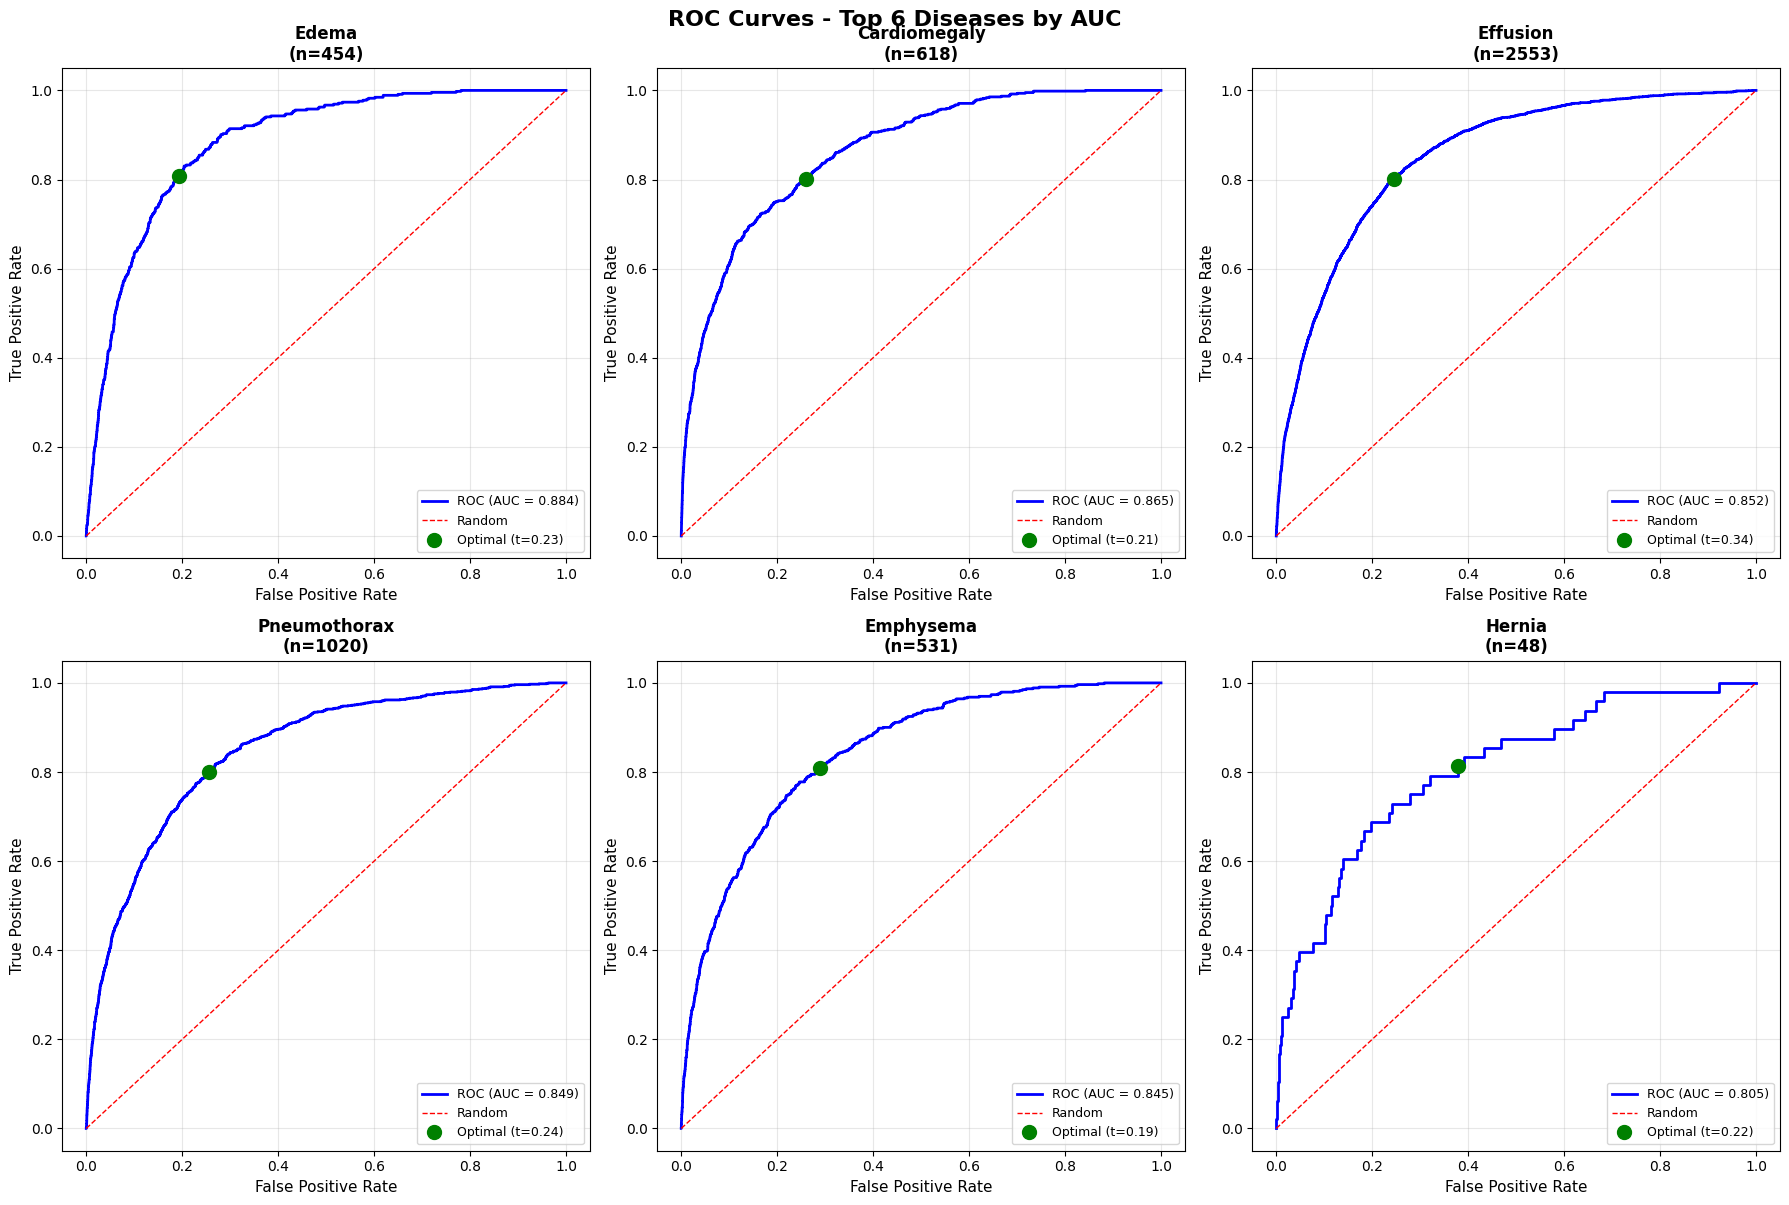

In [33]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

top_diseases = sorted_aucs[:6]

for idx, (disease, auc) in enumerate(top_diseases):
    disease_idx = label_encoder[disease]
    
    fpr, tpr, thresholds = roc_curve(y_test[:, disease_idx], y_pred_probs[:, disease_idx])
    
    axes[idx].plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC (AUC = {auc:.3f})')
    axes[idx].plot([0, 1], [0, 1], 'r--', linewidth=1, label='Random')
    
    optimal_threshold = optimal_thresholds[disease]
    threshold_idx = np.argmin(np.abs(thresholds - optimal_threshold))
    if threshold_idx < len(fpr):
        axes[idx].plot(fpr[threshold_idx], tpr[threshold_idx], 'go', markersize=10, 
                      label=f'Optimal (t={optimal_threshold:.2f})')
    
    axes[idx].set_xlabel('False Positive Rate', fontsize=11)
    axes[idx].set_ylabel('True Positive Rate', fontsize=11)
    axes[idx].set_title(f'{disease}\n(n={int(y_test[:, disease_idx].sum())})', 
                        fontsize=12, fontweight='bold')
    axes[idx].legend(loc='lower right', fontsize=9)
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.suptitle('ROC Curves - Top 6 Diseases by AUC', fontsize=16, fontweight='bold', y=1.00)
plt.show()

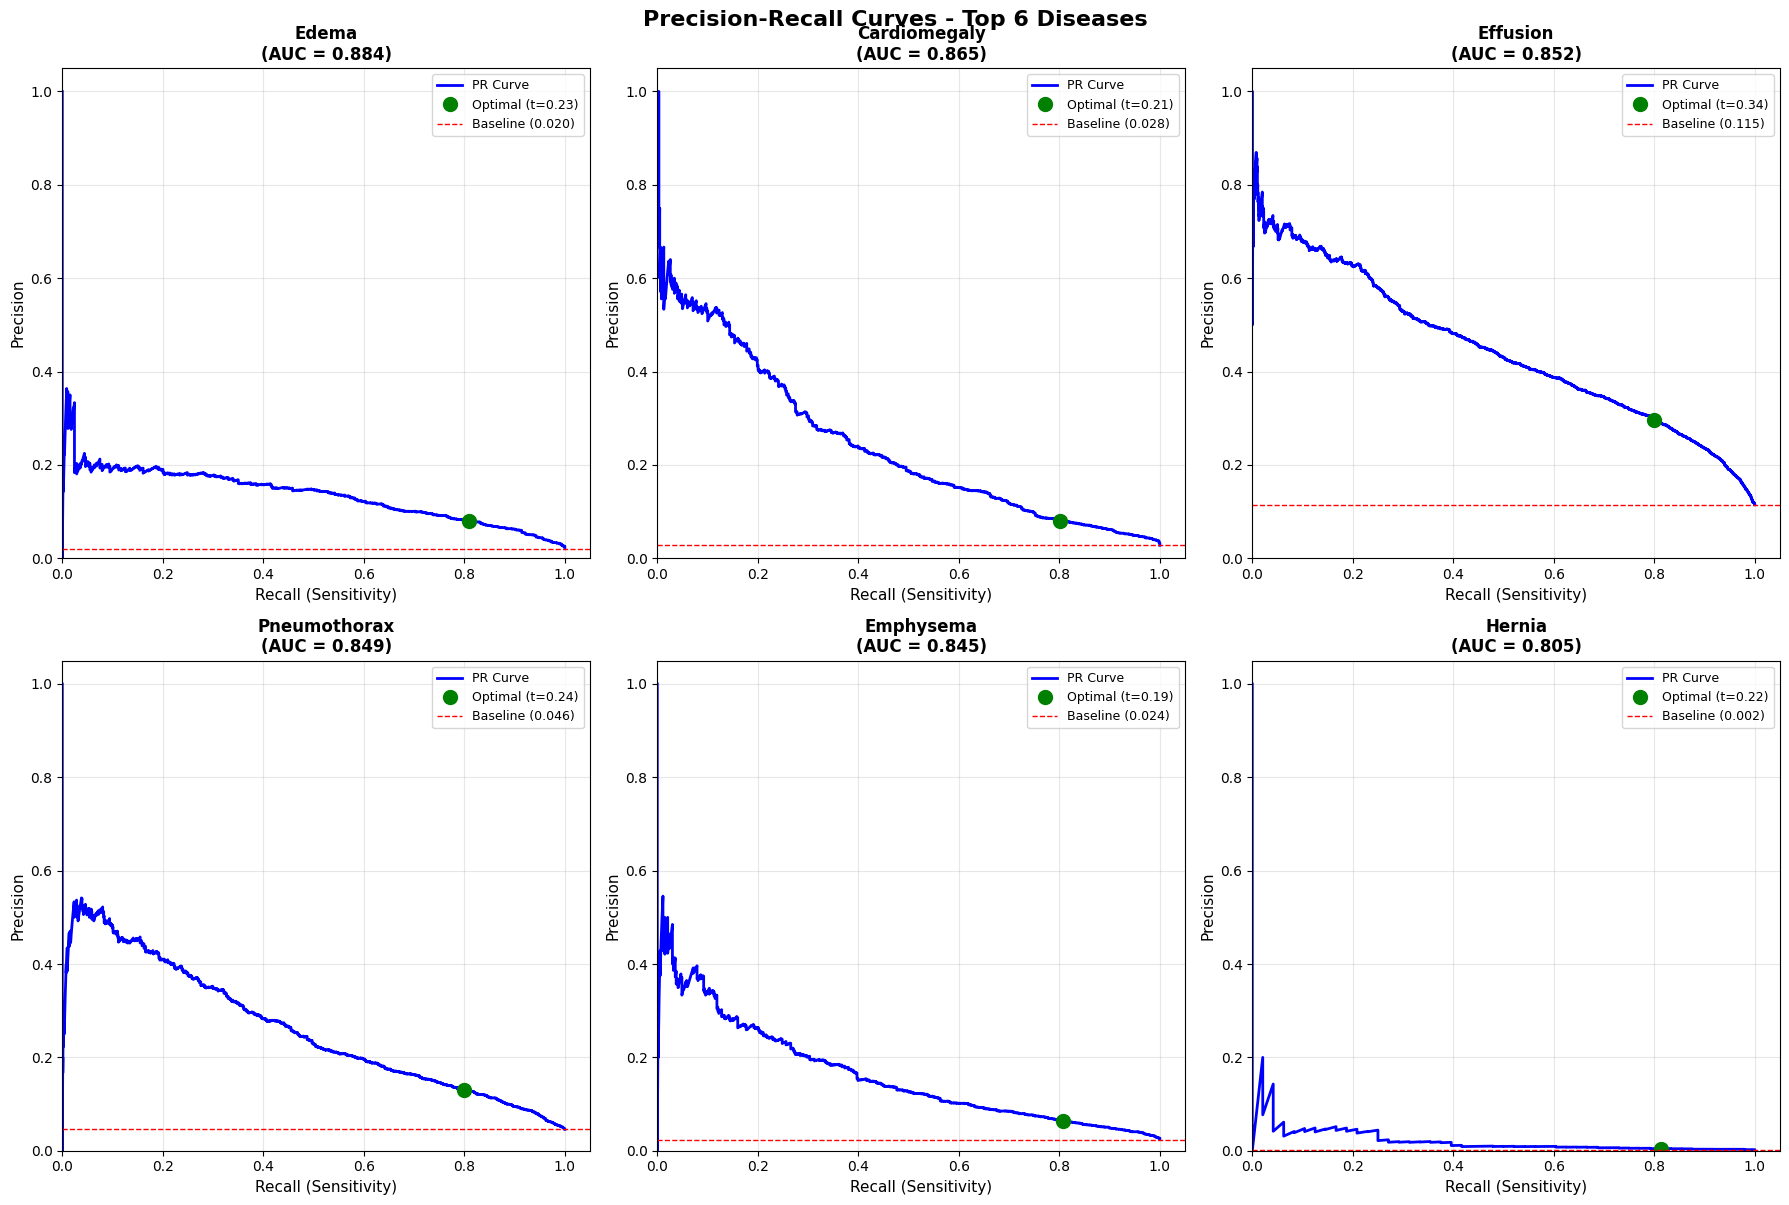

In [34]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, (disease, auc) in enumerate(top_diseases):
    disease_idx = label_encoder[disease]
    
    precision, recall, thresholds = precision_recall_curve(
        y_test[:, disease_idx], 
        y_pred_probs[:, disease_idx]
    )
    
    axes[idx].plot(recall, precision, 'b-', linewidth=2, label='PR Curve')
    
    optimal_threshold = optimal_thresholds[disease]
    optimal_metrics = threshold_metrics[disease]
    opt_recall, opt_precision = optimal_metrics[1], optimal_metrics[2]
    
    axes[idx].plot(opt_recall, opt_precision, 'go', markersize=10, 
                  label=f'Optimal (t={optimal_threshold:.2f})')
    
    baseline = y_test[:, disease_idx].sum() / len(y_test[:, disease_idx])
    axes[idx].axhline(y=baseline, color='r', linestyle='--', linewidth=1, label=f'Baseline ({baseline:.3f})')
    
    axes[idx].set_xlabel('Recall (Sensitivity)', fontsize=11)
    axes[idx].set_ylabel('Precision', fontsize=11)
    axes[idx].set_title(f'{disease}\n(AUC = {auc:.3f})', 
                        fontsize=12, fontweight='bold')
    axes[idx].legend(loc='best', fontsize=9)
    axes[idx].grid(alpha=0.3)
    axes[idx].set_xlim([0, 1.05])
    axes[idx].set_ylim([0, 1.05])

plt.tight_layout()
plt.suptitle('Precision-Recall Curves - Top 6 Diseases', fontsize=16, fontweight='bold', y=1.00)
plt.show()

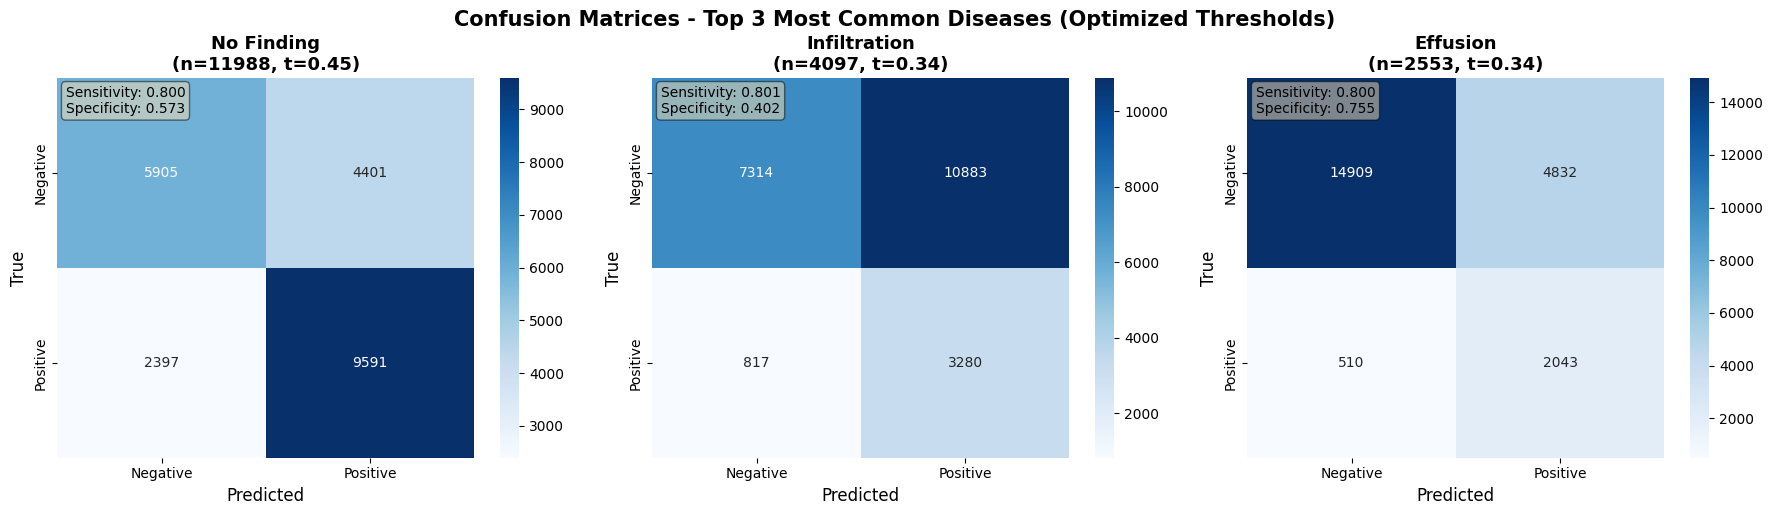

In [35]:
from sklearn.metrics import confusion_matrix

top_3_common = sorted([(d, int(y_test[:, label_encoder[d]].sum())) 
                       for d in disease_names], 
                      key=lambda x: x[1], reverse=True)[:3]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (disease, count) in enumerate(top_3_common):
    disease_idx = label_encoder[disease]
    
    threshold = optimal_thresholds[disease]
    y_true = y_test[:, disease_idx]
    y_pred = (y_pred_probs[:, disease_idx] >= threshold).astype(int)
    
    cm = confusion_matrix(y_true, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    
    axes[idx].set_xlabel('Predicted', fontsize=12)
    axes[idx].set_ylabel('True', fontsize=12)
    axes[idx].set_title(f'{disease}\n(n={count}, t={threshold:.2f})', 
                        fontsize=13, fontweight='bold')
    
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    metrics_text = f'Sensitivity: {sensitivity:.3f}\nSpecificity: {specificity:.3f}'
    axes[idx].text(0.02, 0.98, metrics_text, transform=axes[idx].transAxes,
                   fontsize=10, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.suptitle('Confusion Matrices - Top 3 Most Common Diseases (Optimized Thresholds)', 
             fontsize=15, fontweight='bold', y=1.02)
plt.show()

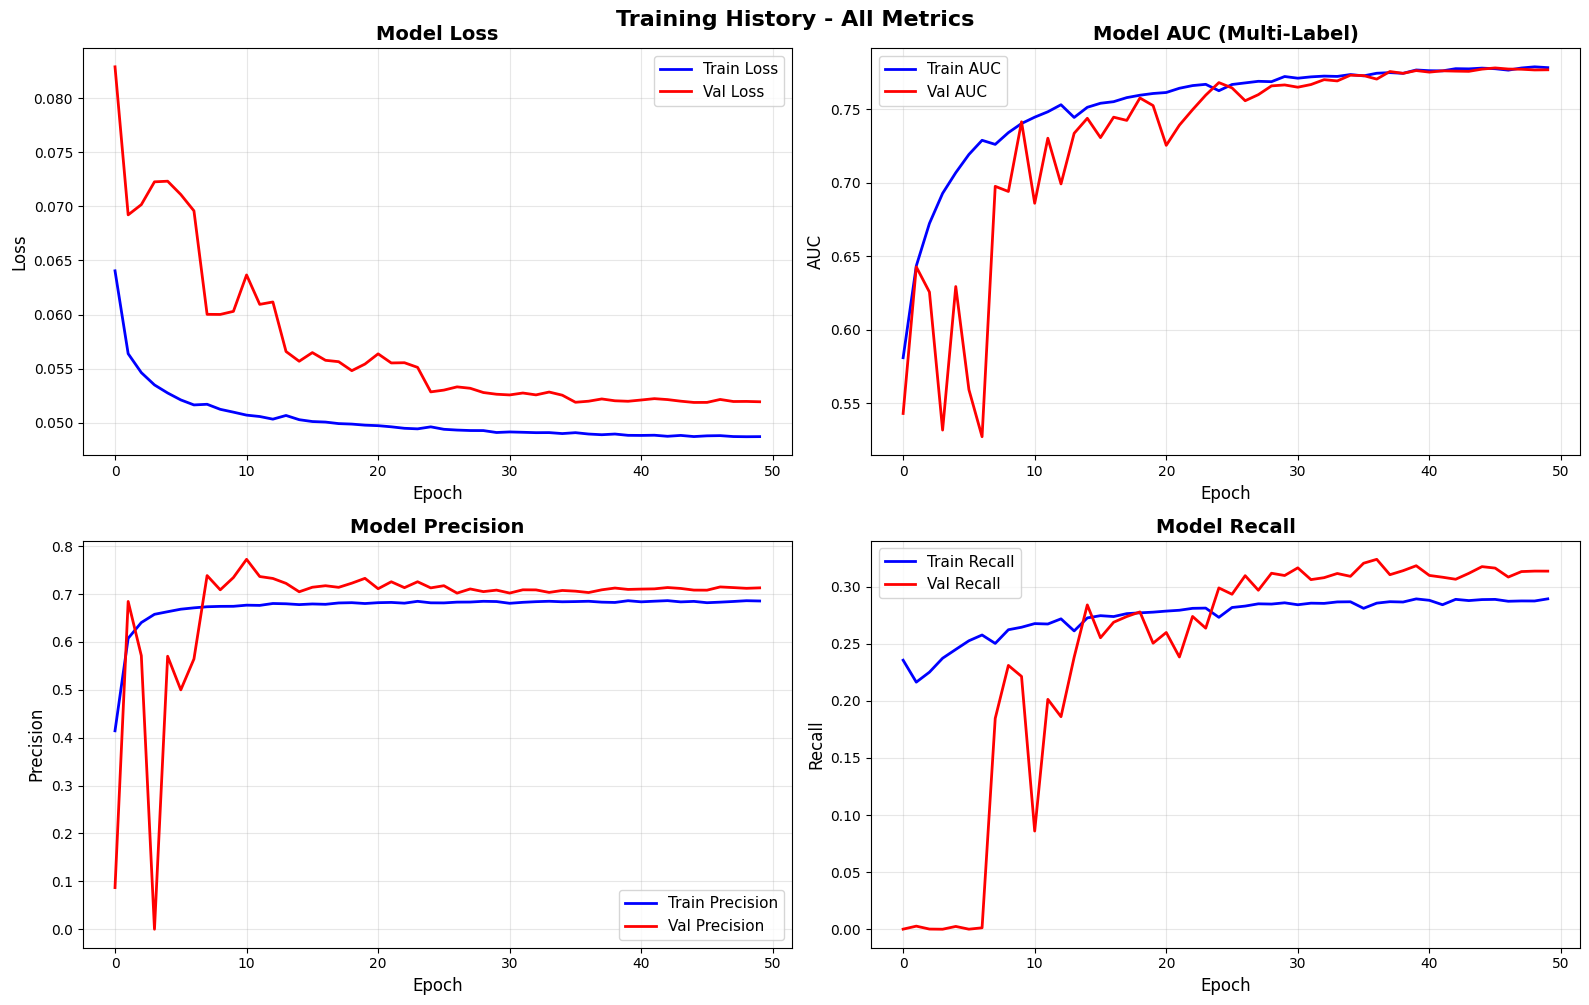


🏆 Best Epoch: 46
   Val AUC: 0.7780
   Val Loss: 0.0519


In [36]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

axes[0, 0].plot(history.history['loss'], 'b-', label='Train Loss', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], 'r-', label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(alpha=0.3)

axes[0, 1].plot(history.history['auc'], 'b-', label='Train AUC', linewidth=2)
axes[0, 1].plot(history.history['val_auc'], 'r-', label='Val AUC', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('AUC', fontsize=12)
axes[0, 1].set_title('Model AUC (Multi-Label)', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(alpha=0.3)

axes[1, 0].plot(history.history['precision'], 'b-', label='Train Precision', linewidth=2)
axes[1, 0].plot(history.history['val_precision'], 'r-', label='Val Precision', linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Precision', fontsize=12)
axes[1, 0].set_title('Model Precision', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(alpha=0.3)

axes[1, 1].plot(history.history['recall'], 'b-', label='Train Recall', linewidth=2)
axes[1, 1].plot(history.history['val_recall'], 'r-', label='Val Recall', linewidth=2)
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Recall', fontsize=12)
axes[1, 1].set_title('Model Recall', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.suptitle('Training History - All Metrics', fontsize=16, fontweight='bold', y=1.00)
plt.show()

best_epoch = np.argmax(history.history['val_auc']) + 1
best_val_auc = np.max(history.history['val_auc'])
print(f"\n🏆 Best Epoch: {best_epoch}")
print(f"   Val AUC: {best_val_auc:.4f}")
print(f"   Val Loss: {history.history['val_loss'][best_epoch-1]:.4f}")

In [37]:
model.save_weights('best_model_final.h5')
print("✅ Weights saved: best_model_final.h5")

import pickle
with open('optimal_thresholds.pkl', 'wb') as f:
    pickle.dump(optimal_thresholds, f)
print("✅ Thresholds saved: optimal_thresholds.pkl")

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("✅ Label encoder saved: label_encoder.pkl")

✅ Weights saved: best_model_final.h5
✅ Thresholds saved: optimal_thresholds.pkl
✅ Label encoder saved: label_encoder.pkl
